--------------------------------------------------------------------------------------------
## Base Model
- Using CNN and RNN in a mixing way

In [1]:
import os, re
import pickle
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications.densenet import DenseNet201

from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [2]:
resources_path = os.path.join('..', '..', 'resources')
path_openAI    = os.path.join(resources_path, 'utils', 'images_weather_description_openAI.csv')
path_ibericam  = os.path.join(resources_path, 'images_ibericam')
path_captions  = os.path.join(resources_path, 'captions.txt')
path_model     = os.path.join(resources_path, 'utils', 'best_model.h5')

### 1. Generate the mapping for captions in the dataset

In [3]:
df_openAI   = pd.read_csv(path_openAI)
df_openAI   = df_openAI.iloc[-301:]

In [4]:
df_aux               = df_openAI[['path_image', 'description']]
df_aux               = df_aux.copy()  # Create a full copy to avoid the warning
df_aux['path_image'] = df_aux['path_image'].apply(lambda x: x.split(os.sep)[-1])
df_aux.columns       = ['image', 'caption']

# Get the name of the images
df_aux['image_name'] = df_aux["image"].str.split('.').str[0]

# Cleaning and formating the dataset before applying LSTM
df_aux['caption_mod'] = df_aux["caption"].apply(lambda caption: [f'startseq "{re.sub("[^A-Za-z . -]", "", caption.lower())}" endseq'])

# Creating a dictinary with the name of the photos and the captions
mapping_dic          = dict(zip(df_aux['image_name'], df_aux['caption_mod']))
list_captions        = df_aux['caption_mod'].values
list_captions        = [item[0] for item in list_captions]

### 2. Load CNN prebuild models
- Modify the preloaded models from keras to:
    - Inputs: mantains the original inputs of the original model
    - Outputs: Takes the second last layer of the model avoiding the last one to be used later as an input to the LSTM

In [5]:
##### 16 layer network using 3x3 convolutions image classification #####
model = VGG16()
##### Dense networks with direct connections among all the layers to improve the gradient flow #####
# model = DenseNet201()
##### Residual networks, prevents performance degradation #####
# model = ResNet152()

model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# print(model.summary())

### 3. Transform the images
- Open the images and adapt it to work with tensorflow

In [6]:
features = {}
list_images_ibercam = glob(os.path.join(path_ibericam, '*.jpg'))

for index, img_path in enumerate(tqdm(list_images_ibercam)):
    
    # load the image from file in a certain format adapted to the model size
    image = load_img(img_path, target_size= (224, 224))#(model.input.shape[1], model.input.shape[2]))
    
    # convert image pixels to numpy array
    image = img_to_array(image)
    
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # preprocess image for tensorflow
    image = preprocess_input(image)
    
    # extract features
    feature = model.predict(image, verbose=0)
    
    # Get image name
    image_id = os.path.splitext(os.path.basename(img_path))[0]
    
    # store feature
    features[image_id] = feature

# Store the features of the images in a pickle file (for saving time for running multiple experiments)
pickle.dump(features, open(os.path.join(resources_path, 'features.pkl'), 'wb'))

  0%|          | 0/6982 [00:00<?, ?it/s]

### 6. Data generator

In [7]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # print(captions)
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

### 4. Tokenizer the text data

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list_captions)
vocab_size = len(tokenizer.word_index) + 1

# Maximum size of one of the captions
max_length = max(len(caption.split()) for caption in list_captions)

### 5. Create LSTM model
- **shape=(4096,)** - output length of the features from the VGG model

- **Dense** - single dimension linear layer array

- **Dropout()** - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

- **model.compile()** - compilation of the model

- **loss=’sparse_categorical_crossentropy’** - loss function for category outputs

- **optimizer=’adam’** - automatically adjust the learning rate for the model over the no. of epochs

- Model plot shows the concatenation of the inputs and outputs into a single layer

- Feature extraction of image was already done using VGG, no CNN model was needed in this step.

In [9]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# print(model.summary())

### 5. Prepare data for trainning
- Train split data

In [10]:
image_ids = list(mapping_dic.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

### 7. Train Model

In [11]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping_dic, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

# Save the best model
model.save(path_model)

8/8 [==============================] - 123s 15s/step - loss: 1.8741


### 8. Generate Captions for the image

In [12]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [13]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    
    for _ in range(max_length):
        # Encode and pad the input sequence
        sequence = pad_sequences([tokenizer.texts_to_sequences([in_text])[0]], maxlen=max_length)
        # Predict the next word
        yhat = np.argmax(model.predict([image, sequence], verbose=0))
        # Convert the predicted index to a word
        word = idx_to_word(yhat, tokenizer)
        
        if not word or word == 'endseq':  # Stop if word not found or end tag is reached
            break
        
        in_text += f" {word}"  # Append the word to the input sequence
    
    return in_text

### 9. Model Validation

In [14]:
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping_dic[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/31 [00:00<?, ?it/s]

BLEU-1: 0.447256
BLEU-2: 0.265840


## 10. Visualize the Results

In [15]:
def generate_caption(img_path):
    image = Image.open(img_path)
    captions = mapping_dic[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq "the cloud base is relatively low indicating the potential for rain. there is a significant presence of medium-level clouds contributing to the overcast conditions and suggesting possible continuous rain or storms. despite the absence of low clouds the high percentage of high clouds indicates changes in weather likely hinting at an approaching front. overall the sky is largely overcast which points towards continuous rain or storm activity." endseq
--------------------Predicted--------------------
startseq the cloud base is at a moderate altitude suggesting stable weather conditions the sky is completely overcast with dense low clouds indicating clear skies and potential for light showers the moderate presence of low clouds suggests possible light showers overall the sky is mostly cloudy indicating overcast conditions with potential for light rain


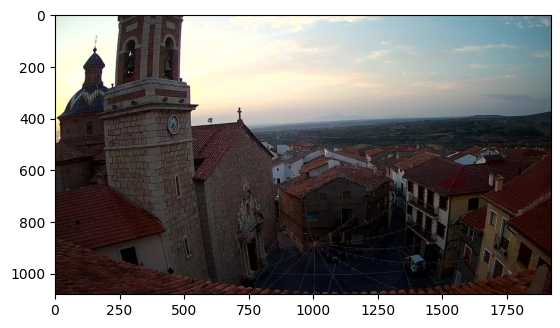

In [16]:
generate_caption("../../resources/images_ibericam/el-pobo-20240822-073001.jpg")